In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import numpy as np

In [3]:
species_id = pd.read_csv("../data/sample_genus_and_species.csv", header=None, 
                         names = ["sample", 'genus', 'species'], index_col = 0)

In [4]:
k21sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k21.csv")
k31sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k31.csv")
k51sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k51.csv")

In [5]:
k21sim.index = k21sim.columns
k21sim.columns = species_id.loc[k21sim.columns.tolist()]['species'].values

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [6]:
k21sim

,erythrothorax,tarsalis,particeps,tarsalis,particeps,pipiens,incidens,erythrothorax,particeps,nan
CMS_010_RNA_A_S1,1.000000,0.896652,0.463246,0.841984,0.484420,0.797447,0.493074,0.789153,0.294949,0.899803
CMS_002_RNA_A_S1,0.896652,0.999999,0.447920,0.834960,0.464487,0.790712,0.468954,0.794285,0.273163,0.940764
CMS_008_RNA_A_S3,0.463246,0.447920,1.000000,0.431753,0.856831,0.476470,0.821585,0.421809,0.633917,0.448911
CMS_001_RNA_A_S1,0.841984,0.834960,0.431753,1.000000,0.466886,0.764668,0.481471,0.826892,0.299204,0.872819
CMS_003_RNA_A_S2,0.484420,0.464487,0.856831,0.466886,0.999999,0.500629,0.879964,0.452047,0.608665,0.468676
CMS_004_RNA_A_S2,0.797447,0.790712,0.476470,0.764668,0.500629,0.999999,0.509379,0.708559,0.293527,0.784353
CMS_005_RNA_A_S3,0.493074,0.468954,0.821585,0.481471,0.879964,0.509379,1.000000,0.457557,0.575371,0.476193
CMS_007_RNA_A_S12,0.789153,0.794285,0.421809,0.826892,0.452047,0.708559,0.457557,1.000000,0.325356,0.830322
CMS_009_RNA_A_S13,0.294949,0.273163,0.633917,0.299204,0.608665,0.293527,0.575371,0.325356,0.999999,0.287991
CMS_0015_RNA_A_S13,0.899803,0.940764,0.448911,0.872819,0.468676,0.784353,0.476193,0.830322,0.287991,1.000000


In [11]:
k31sim

,CMS_008_RNA_A_S3,CMS_0015_RNA_A_S13,CMS_010_RNA_A_S1,CMS_009_RNA_A_S13,CMS_002_RNA_A_S1,CMS_003_RNA_A_S2,CMS_001_RNA_A_S1,CMS_004_RNA_A_S2,CMS_007_RNA_A_S12,CMS_005_RNA_A_S3
0,1.000000,0.367305,0.367568,0.763645,0.389954,0.933168,0.357995,0.419868,0.370745,0.808011
1,0.367305,0.999999,0.893226,0.374518,0.521634,0.338874,0.885641,0.628329,0.809337,0.326683
2,0.367568,0.893226,1.000000,0.380391,0.531026,0.340164,0.911770,0.646265,0.845329,0.326180
3,0.763645,0.374518,0.380391,1.000000,0.397838,0.755912,0.358428,0.426520,0.409284,0.690460
4,0.389954,0.521634,0.531026,0.397838,1.000000,0.358831,0.508211,0.618442,0.543497,0.345047
5,0.933168,0.338874,0.340164,0.755912,0.358831,1.000000,0.333584,0.385543,0.340686,0.804332
6,0.357995,0.885641,0.911770,0.358428,0.508211,0.333584,0.999998,0.613850,0.790010,0.321209
7,0.419868,0.628329,0.646265,0.426520,0.618442,0.385543,0.613850,0.999999,0.667935,0.371070
8,0.370745,0.809337,0.845329,0.409284,0.543497,0.340686,0.790010,0.667935,0.999999,0.332063
9,0.808011,0.326683,0.326180,0.690460,0.345047,0.804332,0.321209,0.371070,0.332063,1.000000


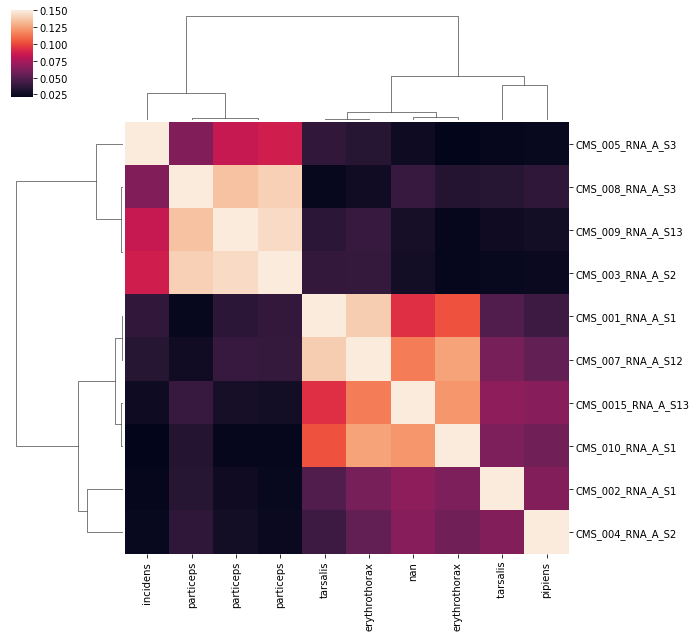

In [74]:
sns.clustermap(k21sim - 0.85*np.eye(10), metric = 'cosine')

In [75]:
k31sim.index = k31sim.columns
k31sim.columns = species_id.loc[k31sim.columns.tolist()]['species'].values

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


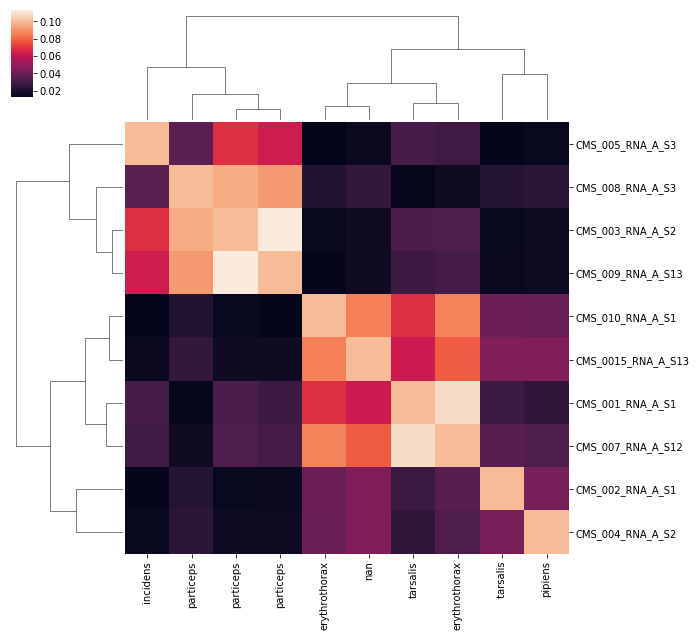

In [79]:
sns.clustermap(k31sim - 0.9*np.eye(10))

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


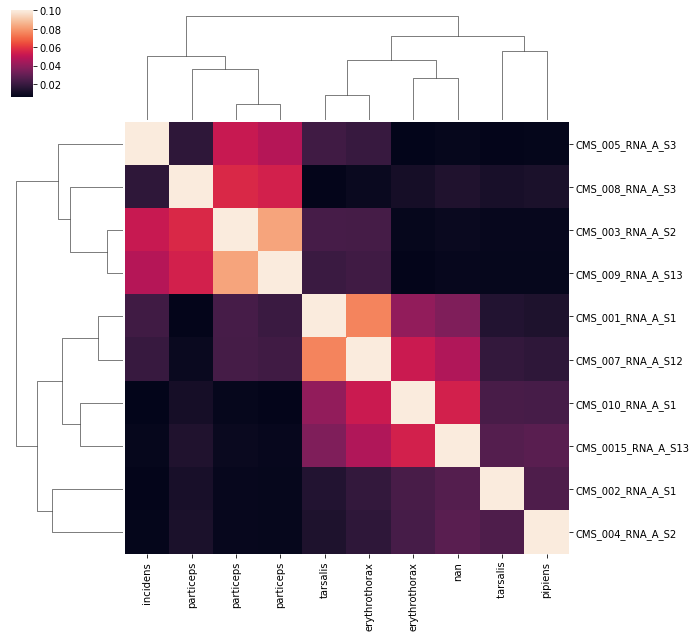

In [78]:
k51sim.index = k51sim.columns
k51sim.columns = species_id.loc[k51sim.columns.tolist()]['species'].values
sns.clustermap(k51sim - 0.9*np.eye(10))

In [83]:
! aws s3 ls s3://czbiohub-mosquito/references/sourmash/comparison/

2018-08-15 17:36:24       2000 k21.csv
2018-08-15 17:35:38       2003 k31.csv
2018-08-15 17:35:28       2009 k51.csv


In [25]:
k21sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k21abun.csv")
k31sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k31abun.csv")
k51sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k51abun.csv")

In [22]:
len(k31sim)

87

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


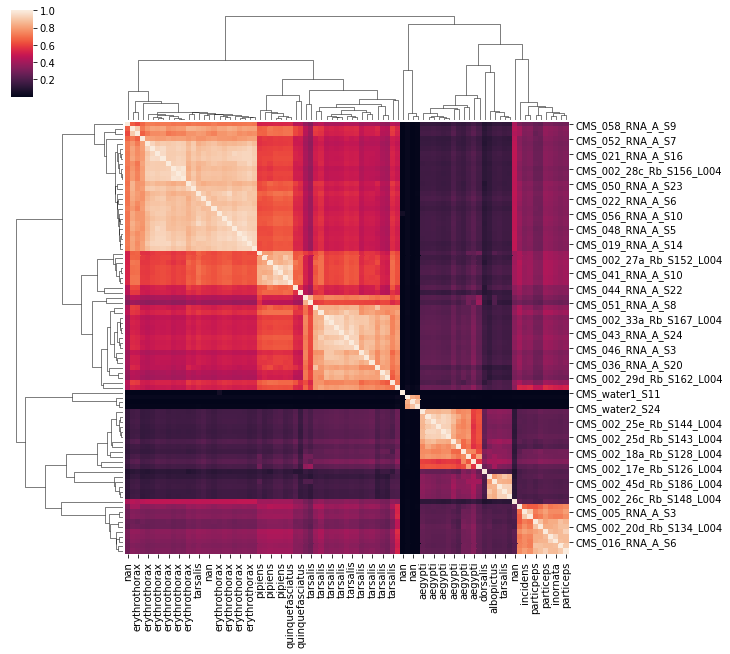

In [19]:
k31sim.index = k31sim.columns
k31sim.columns = species_id.loc[k31sim.columns.tolist()]['species'].values
sns.clustermap(k31sim,  figsize = (20,20))

In [45]:
for i, j in zip(k51sim.columns, k51sim.index):
    print(i,j)

tarsalis CMS_051_RNA_A_S8
pipiens CMS_044_RNA_A_S22
erythrothorax CMS_018_RNA_A_S14
tarsalis CMS_043_RNA_A_S24
nan Undetermined_S0
erythrothorax CMS_010_RNA_A_S1
erythrothorax CMS_023_RNA_A_S17
dorsalis CMS_012_RNA_A_S4
tarsalis CMS_045_RNA_A_S2
inornata CMS_016_RNA_A_S6
particeps CMS_003_RNA_A_S2
aegypti CMS_002_17e_Rb_S126_L004
tarsalis CMS_002_33a_Rb_S167_L004
erythrothorax CMS_002_28e_Rb_S158_L004
particeps CMS_008_RNA_A_S3
aegypti CMS_002_25a_Rb_S140_L004
aegypti CMS_002_44c_Rb_S180_L004
albopictus CMS_002_45d_Rb_S186_L004
particpeps CMS_002_20a_Rb_S131_L004
tarsalis CMS_027_RNA_A_S16
erythrothorax CMS_056_RNA_A_S10
tarsalis CMS_002_39a_Rb_S173_L004
tarsalis CMS_026_RNA_A_S18
particpeps CMS_002_20e_Rb_S135_L004
nan CMS_water4_Zymo_S27
tarsalis CMS_028_RNA_A_S17
quinquefasciatus CMS_002_22a_Rb_S137_L004
erythrothorax CMS_007_RNA_A_S12
tarsalis CMS_046_RNA_A_S3
nan CMS_0015_RNA_A_S13
erythrothorax CMS_053_RNA_A_S8
erythrothorax CMS_024_RNA_A_S15
pipiens CMS_041_RNA_A_S10
aegypti CMS

There does seem to be some discordance between between labels and this clustering, and also between this clustering and lucy's COI analysis

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


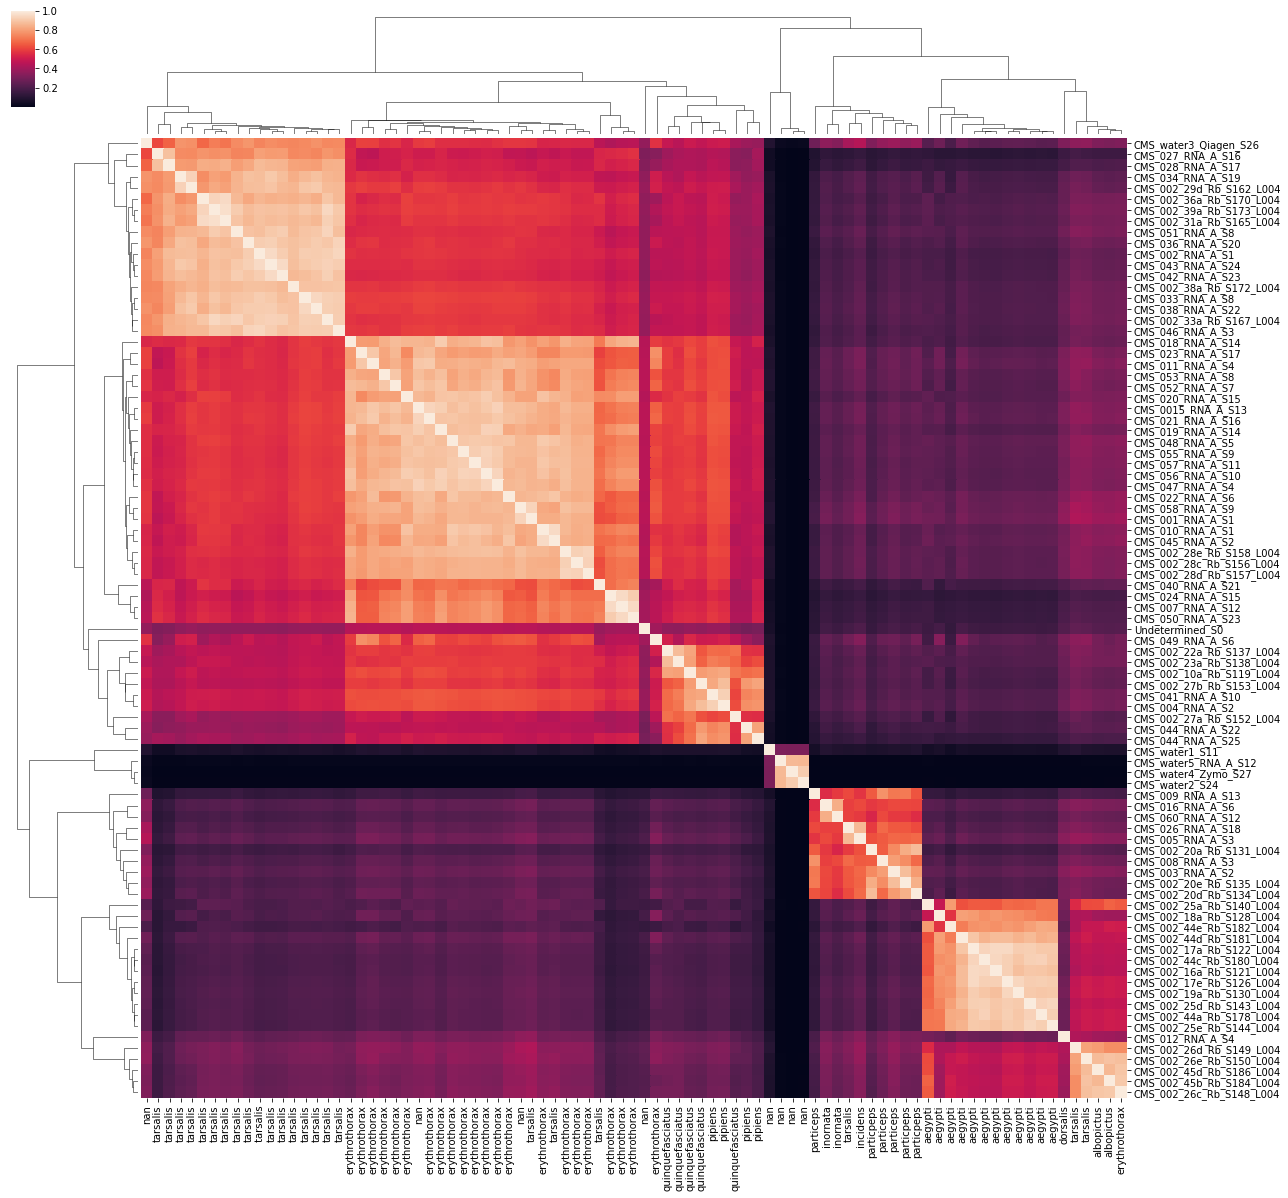

In [26]:
k51sim.index = k51sim.columns
k51sim.columns = species_id.loc[k51sim.columns.tolist()]['species'].values
sns.clustermap(k51sim, figsize = (20,20))

In [86]:
k21sim.index = k21sim.columns
k21sim.columns = species_id.loc[k21sim.columns.tolist()]['species'].values
sns.clustermap(k21sim)

,erythrothorax,tarsalis,particeps,tarsalis,particeps,pipiens,incidens,erythrothorax,particeps,nan
CMS_010_RNA_A_S1,1.000000,0.896652,0.463246,0.841984,0.484420,0.797447,0.493074,0.789153,0.294949,0.899803
CMS_002_RNA_A_S1,0.896652,0.999999,0.447920,0.834960,0.464487,0.790712,0.468954,0.794285,0.273163,0.940764
CMS_008_RNA_A_S3,0.463246,0.447920,1.000000,0.431753,0.856831,0.476470,0.821585,0.421809,0.633917,0.448911
CMS_001_RNA_A_S1,0.841984,0.834960,0.431753,1.000000,0.466886,0.764668,0.481471,0.826892,0.299204,0.872819
CMS_003_RNA_A_S2,0.484420,0.464487,0.856831,0.466886,0.999999,0.500629,0.879964,0.452047,0.608665,0.468676
CMS_004_RNA_A_S2,0.797447,0.790712,0.476470,0.764668,0.500629,0.999999,0.509379,0.708559,0.293527,0.784353
CMS_005_RNA_A_S3,0.493074,0.468954,0.821585,0.481471,0.879964,0.509379,1.000000,0.457557,0.575371,0.476193
CMS_007_RNA_A_S12,0.789153,0.794285,0.421809,0.826892,0.452047,0.708559,0.457557,1.000000,0.325356,0.830322
CMS_009_RNA_A_S13,0.294949,0.273163,0.633917,0.299204,0.608665,0.293527,0.575371,0.325356,0.999999,0.287991
CMS_0015_RNA_A_S13,0.899803,0.940764,0.448911,0.872819,0.468676,0.784353,0.476193,0.830322,0.287991,1.000000


In [ ]:
k51sim.index = k51sim.columns
k51sim.columns = species_id.loc[k51sim.columns.tolist()]['species'].values
sns.clustermap(k51sim - 0.9*np.eye(10))

In [70]:
species_id.loc[k21sim.columns.tolist()]['species'].values

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


array(['tarsalis', ' tarsalis', 'erythrothorax', 'pipiens', 'particeps',
       nan, 'particeps', 'incidens', 'particeps', 'erythrothorax'],
      dtype=object)

In [55]:
species_id.loc['CMS_0015_RNA_A_S13']

KeyError: 'the label [CMS_0015_RNA_A_S13] is not in the [index]'